## 분석
- train은 15951 그 중 양성: 2158 음성: 13793
- test는 400 그 중 양성 198 음성: 202
- 사진 데이터의 크기는 제각각 -> 이는 500 x 500의 BGR 3채널 데이터로 resize를 진행한다.
- 사진 데이터 1개를 resize해서 메모리에 올리면 대략 0.73MB가 증가 -> 1000개를 불러서 array에 저장했을 때 732.55MB
- 학습 컨테이너를 만들자. 학습 컨테이너에서 데이터를 읽어서 저장(block_size) -> 학습 함수 호출 -> 반복
- 학습 함수를 만들어서 parameter로 각종 정보를 가지는 dict 자료형을 사용해보자
- 학습 함수에는 모델, batch_size(한번에 학습시킬 데이터 수), 학습 데이터를 받아서 사용
- 여기에서 sci-kit learn의 train_test_split을 사용해보자!
- split하고 train은 기존 데이터를 사용하고 test데이터를 validation 데이터로 사용
- ex) 1000개 중 200개를 validation 데이터로 사용하되 학습은 1000개 모두 사용.

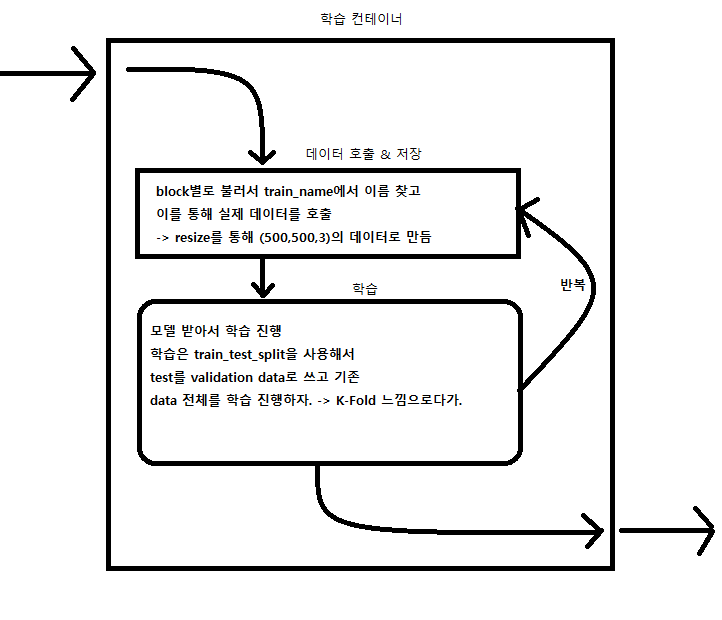

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


**KAGGLE**

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

In [ ]:
%mkdir '/content/COVID_XRAY/'
%cd '/content/COVID_XRAY/'

mkdir: cannot create directory ‘/content/COVID_XRAY/’: File exists
/content/COVID_XRAY


In [ ]:
!kaggle datasets download -d andyczhao/covidx-cxr2

 15% 1.68G/11.6G [00:11<01:08, 156MB/s]
User cancelled operation


In [ ]:
%ls

competition_test/  covidx-cxr2.zip  test/  test.txt  train/  train.txt


In [ ]:
!unzip **.zip && rm *.zip

Archive:  covidx-cxr2.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of covidx-cxr2.zip or
        covidx-cxr2.zip.zip, and cannot find covidx-cxr2.zip.ZIP, period.


In [ ]:
%cd '/content/'

/content


**import**

In [ ]:
import pandas as pd
import cv2
import time
import numpy as np
import sys

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
!pip install memory_profiler
%load_ext memory_profiler
%memit

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
peak memory: 397.36 MiB, increment: 0.00 MiB


In [ ]:
class COVID:
    def __init__(self):
        # initialization
        # temp = '/content/drive/MyDrive/Colab Notebooks/'
        temp = './'
        self._train = pd.read_csv(temp + 'COVID_XRAY/train.txt',sep = " ", engine='python',names = ['Data_ID','File_Name','Result','Reference'])
        self._test = pd.read_csv(temp + 'COVID_XRAY/test.txt',sep = " ", engine='python',names = ['Data_ID','File_Name','Result','Reference'])
        self.__train_path = temp + 'COVID_XRAY/train/'
        self.__test_path = temp + 'COVID_XRAY/test/'
        self.__data_size = 250
        self.__seed = 123
        self.__align = True
        self._data_shuffle()
    
    def _data_shuffle(self):
        # data shuffle
        self._train = self._train.sample(frac=1, replace=True, random_state=self.__seed)
        self._test = self._test.sample(frac=1, replace=True, random_state=self.__seed)
        if self.__align is True:
            self._data_alignment()
        else:
            self._data_extraction()
            
    def _data_alignment(self):
        self.__train_neg = self._train.query("Result == 'negative'")
        self.__train_pos = self._train.query("Result == 'positive'")
        self._data_extraction()
        
    def _data_extraction(self):
        # data name and label divide
        self.__train_name = self._train.iloc[:,1]
        self.__train_label = self._train.iloc[:,2]
        self.__test_name = self._test.iloc[:,1]
        self.__test_label = self._test.iloc[:,2]
        self._encoding()
        
    def _encoding(self):
        encoder = LabelEncoder()
        self.__train_label = encoder.fit_transform(self.__train_label)
        self.__test_label = encoder.fit_transform(self.__test_label)
#         self.data_verification()
    
    def _data_remake(self,block_num = 0): # BAD CODE!!!!
        start = len(self.__train_pos) * block_num 
        end = len(self.__train_pos) * (block_num + 1)
#         if end > len(__train_neg):
#             end = len(__train_neg)
        print(start, end,len(self.__train_neg))
        if end < len(self.__train_neg):
            encoder = LabelEncoder()
            self.__train_remake = self.__train_neg.iloc[start:end,:]
            self.__train_remake = self.__train_remake.append(self.__train_pos, ignore_index = True)
            self.__train_remake = self.__train_remake.sample(frac=1, replace=True)#, random_state=self.__seed)
            self.__train_remake_name = self.__train_remake.iloc[:,1]
            self.__train_remake_label = self.__train_remake.iloc[:,2]
            self.__train_remake_label = encoder.fit_transform(self.__train_remake_label)

        
    def data_verification(self):
        # data information 출력
        if self.__align is True:
            print('neg:',self.__train_neg.head())
            print('neg length',len(self.__train_neg))
            print('pos:',self.__train_pos.head())
            print('pos length',len(self.__train_pos))
        else:
            print('train:',self._train.head())
            print('test:',self._test.head())
            print('size of train data :', len(self.__train_name))
            print('size of test data :', len(self.__test_name))
            print('train data pos vs neg ratio :', self._train[2].value_counts())
            print('test data pos vs neg ratio :', self._test[2].value_counts())
    
    def show_data_example(self):
        # 이미지 데이터 불러서 예시로 확인해보기.
        data = cv2.imread(self.__train_path + self.__train_name[0],cv2.IMREAD_COLOR)
        data = cv2.resize(data, (self.__data_size,self.__data_size), interpolation = cv2.INTER_AREA)
        data_r = data[:,:,0]
        data_g = data[:,:,1]
        data_b = data[:,:,2]
        cv2.imshow('original', data)
        cv2.imshow('r_channel', data_r)
        cv2.imshow('g_channel', data_g)
        cv2.imshow('b_channel', data_b)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
    def modeling(self):
        self.model = keras.Sequential()
        self.model.add(keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(self.__data_size,self.__data_size,3))) #82개의 3x3 matrix filters)
        self.model.add(keras.layers.MaxPool2D((2,2))) #2x2 size의 Max Pooling 2D Matrix
        self.model.add(keras.layers.Dropout(0.2)) #0.2%의 확률로 dropout
        self.model.add(keras.layers.Conv2D(128,(3,3),activation='relu')) # 전 단계 필터 수의 2배인 164개의 3x3 matrix filters
        self.model.add(keras.layers.MaxPool2D((2,2))) #2x2 size의 Max Pooling 2D Matrix
        self.model.add(keras.layers.Dropout(0.3)) #0.3%의 확률로 dropout
        self.model.add(keras.layers.Flatten()) #dropout했을 때의 차원과 filter 개수를 곱해서 쭉 늘임
        self.model.add(keras.layers.Dense(64,activation='relu'))
        self.model.add(keras.layers.Dense(32,activation='relu'))
        self.model.add(keras.layers.Dense(16,activation='relu'))
        self.model.add(keras.layers.Dense(1,activation='sigmoid'))
        self.model.compile(optimizer='adam',#정규화기
              loss='binary_crossentropy', #손실함수
              metrics=['accuracy','Precision','Recall']) #기준리스트
        self.model.summary()
        keras.utils.plot_model(self.model, show_shapes=True)
    
    # data load
    def __data_loading(self,start = 0,end = 500,typ='tr'):
        # start : index of start block -> ex) 0
        # end : index of end block -> ex) 1000
        if typ == 'tr':
            name_list = self.__train_name
            path = self.__train_path
        elif typ == 'te': # typ == 'te'
            name_list = self.__test_name
            path = self.__test_path
            start = 0
            end = len(self.__test_name)
        elif typ == 're': # remake data
            name_list = self.__train_remake_name
            path = self.__train_path
            start = 0
            end = len(self.__train_remake_name)
        else:
            return None
        image = []
        start_time = time.time()
        for i, name in enumerate(name_list):
            sys.stdout.write('\rloading start: {0}'.format(i))
            if i < start:
                continue
            if i > end :
                break;
            fname = path + name
            data = cv2.imread(fname,cv2.IMREAD_COLOR)
            data = cv2.resize(data, (self.__data_size,self.__data_size), interpolation = cv2.INTER_AREA)
            image.append(data)
#         %memit
        image = np.array(image)
        print('Time Eleapsed: {0:.4}ms'.format(time.time()-start))
        print(image.shape)
        return image
    # train
    def __train(self,data,typ = 'tr'):
        #data = data
#         print(self.__train_label.shape)
        if typ == 'tr':
            label = self.__train_label[start:end+1]
        elif typ == 're':
            label = self.__train_remake_label
        print(label.shape)
        x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=self.__seed, stratify = label)
        %memit
        self.model.fit(data,label,epochs = 5, validation_data=(x_test,y_test))
        %memit
        
    def train_container(self):
#         block_size = 1000
        block_size = len(self.__train_pos)
        num_block = round(len(self.__train_name)/block_size)
        epochs = 3
        self.modeling()        
        

        for epoch in range(epochs):
            # self._data_shuffle()
            print("epoch {0}:".format(epoch))
            for iteration in range(num_block):
#                 start = iteration * block_size
#                 end = (iteration+1) * block_size
                print("    block {0}:".format(iteration))
                self._data_remake(iteration)
                data = self.__data_loading(typ = 're')
#                 data = self.__data_loading(start,end, typ = 'tr')
                %memit
                self.__train(data,typ = 're')
#                 self.__train(data,typ = 'tr')

                
    def test(self):
        data = self.__data_loading(typ='te')
        self.model.evaluate(data , self.__test_label)
    
    def predict(self):
        prediction = self.model.predict(self.__data_loading(typ='te'))
        total = len(prediction)
        correct = 0 # 304/400
        for i, data in enumerate(prediction):
            if data >= 0.5:
                data = 1
            else:
                data = 0
            if(data == self.__test_label[i]):
                correct = correct + 1
            else:
                print('Perdict : ',data, 'Label : ',self.__test_label[i])
        print("total : {0}, answer : {1}, accuracy : {2:.4}%".format(total, correct, correct / total * 100))
        return prediction, self.__test_label


In [ ]:
test = COVID()

In [ ]:
%memit

peak memory: 408.71 MiB, increment: 0.02 MiB


규모가 너무 커서 16GB램이 터지려고 함...

이 부분은 Google Colab에서 학습을 진행하려하니 구글드라이브가 말썽이라 드라이브 100GB 결제함...

In [ ]:
test.train_container()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 248, 248, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 124, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 124, 124, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 61, 61, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 476288)            0

In [ ]:
test.test()

In [ ]:
pred, ans = test.predict()
total = len(pred)
correct = 0 # 304/400
for i, data in enumerate(pred):
  if data >= 0.5:
    data = 1
  else:
    data = 0
  if(data == ans[i]):
    correct = correct + 1
  else:
    print('Perdict : ',data, 'Label : ',ans[i])
print("total : {0}, answer : {1}, accuracy : {2:.4}%".format(total, correct, correct / total * 100))

loading start: 399Time Eleapsed: 1.623e+09ms
(400, 250, 250, 3)
Perdict :  1 Label :  0
Perdict :  0 Label :  1
Perdict :  0 Label :  1
Perdict :  0 Label :  1
Perdict :  0 Label :  1
Perdict :  0 Label :  1
Perdict :  1 Label :  0
Perdict :  0 Label :  1
Perdict :  0 Label :  1
Perdict :  0 Label :  1
Perdict :  1 Label :  0
Perdict :  0 Label :  1
Perdict :  0 Label :  1
Perdict :  0 Label :  1
Perdict :  1 Label :  0
Perdict :  0 Label :  1
Perdict :  0 Label :  1
Perdict :  0 Label :  1
Perdict :  0 Label :  1
Perdict :  0 Label :  1
Perdict :  1 Label :  0
Perdict :  0 Label :  1
Perdict :  1 Label :  0
Perdict :  0 Label :  1
Perdict :  0 Label :  1
Perdict :  0 Label :  1
Perdict :  0 Label :  1
Perdict :  0 Label :  1
Perdict :  0 Label :  1
Perdict :  0 Label :  1
Perdict :  0 Label :  1
Perdict :  0 Label :  1
Perdict :  0 Label :  1
Perdict :  0 Label :  1
Perdict :  1 Label :  0
Perdict :  0 Label :  1
Perdict :  0 Label :  1
Perdict :  0 Label :  1
Perdict :  0 Label :  1


오류 96개 중 거짓 음성이 82개 거짓 양성이 14<br>
양성 198개 중 116개만 가려냈고 14개를 거짓 양성으로 판정.